<a href="https://colab.research.google.com/github/JohnGiorgi/DeCLUTR/blob/master/notebooks/embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding text with an existing model

This notebook will walk you through embedding some text with a pretrained model using [DeCLUTR](https://github.com/JohnGiorgi/DeCLUTR). You can embed text in one of four ways:

1. __SentenceTransformers__: load our pretrained models with the [SentenceTransformers](https://www.sbert.net/) library (_recommended_).
2. __🤗 Transformers__: load our pretrained models with the [🤗 Transformers library](https://github.com/huggingface/transformers).
3. __From this repo__: import and initialize an object from this repo which can be used to embed sentences/paragraphs.
4. __Bulk embed__: embed all text in a given text file with a simple command-line interface.

The following pre-trained models are available:

- [johngiorgi/declutr-small](https://huggingface.co/johngiorgi/declutr-small)
- [johngiorgi/declutr-base](https://huggingface.co/johngiorgi/declutr-base)
- [johngiorgi/declutr-sci-base](https://huggingface.co/johngiorgi/declutr-sci-base)

Each approach has advantages and disadvantages:

1. __SentenceTransformers__: This is the easiest way to use DeCLUTR, but it requires that you [install the SentenceTransformers library](https://www.sbert.net/docs/installation.html) first.
2. __🤗 Transformers__: This only requires you to install the [🤗 Transformers library](https://github.com/huggingface/transformers), but requires more boilerplate code.
3. __From this repo__: This is the easiest way to use your own models trained with [our repo](https://github.com/JohnGiorgi/DeCLUTR), but requires you to [install DeCLUTR](https://github.com/JohnGiorgi/DeCLUTR#installation).
4. __Bulk embed__: This might be suitable if you want to embed large quantities of text "offline" (e.g. not on-the-fly within an existing pipeline), but requires you to [install DeCLUTR](https://github.com/JohnGiorgi/DeCLUTR#installation).

## 🔧 Prerequisites

Finally, let's check to see if we have a GPU available, which we can use to dramatically speed up the embedding of text

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## 1️⃣ SentenceTransformers

Our pretrained models are hosted with Hugging Face Transformers, so they can easily be loaded in SentenceTransformers. Just make sure to [install the SentenceTransformers library](https://www.sbert.net/docs/installation.html) first:

In [ ]:
!pip install -U sentence-transformers

Here is a simple example using [DeCLUTR-small](https://huggingface.co/johngiorgi/declutr-small):

In [ ]:
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer("johngiorgi/declutr-small", device=device)

# Prepare some text to embed
texts = [
    "A smiling costumed woman is holding an umbrella.",
    "A happy woman in a fairy costume holds an umbrella.",
    "A soccer game with multiple males playing.",
    "Some men are playing a sport.",
]

# Embed the text
embeddings = model.encode(texts)

These embeddings can then be used, for example, to compute the semantic similarity between some number of sentences or paragraphs.

In [5]:
from scipy.spatial.distance import cosine

# Compute a semantic similarity via the cosine distance
semantic_sim = 1 - cosine(embeddings[0], embeddings[1])
print(semantic_sim)

0.8356759548187256


Mainly for fun, the following cells visualize the semantic similarity with a heatmap!

In [6]:
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns

def plot_heatmap(text: List[str], embeddings: np.ndarray) -> None:
    embeddings = torch.as_tensor(embeddings)
    cosine = torch.nn.CosineSimilarity(-1)
    similarity_matrix = []
    for _, embedding in enumerate(embeddings):
        similarity_vector = cosine(embedding, embeddings)
        similarity_vector = similarity_vector.numpy()
        similarity_matrix.append(similarity_vector)
    df = pd.DataFrame(similarity_matrix)
    df.columns = df.index = text
    sns.heatmap(df, cmap="YlOrRd")

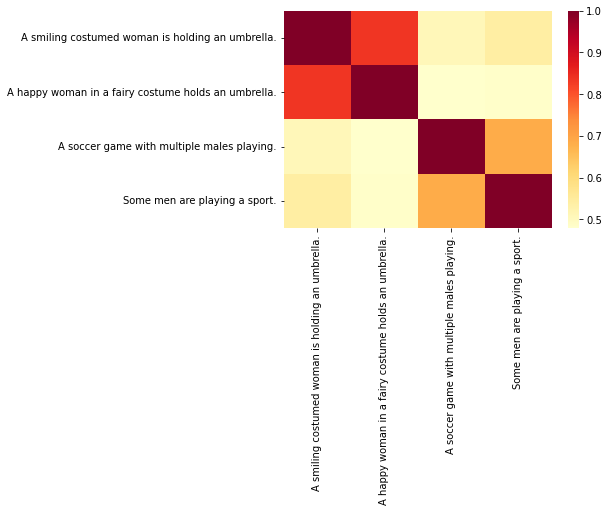

In [7]:
plot_heatmap(texts, embeddings)

## 2️⃣ 🤗 Transformers

Alternatively, you can use the models straight from Hugging Face Transformers. This just requires a few extra steps. Just make sure to [install the Transformers library](https://huggingface.co/docs/transformers/installation) first:

In [ ]:
!pip install -U transformers

Here is a simple example using [DeCLUTR-small](https://huggingface.co/johngiorgi/declutr-small):

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

# Load the model
tokenizer = AutoTokenizer.from_pretrained("johngiorgi/declutr-small")
model = AutoModel.from_pretrained("johngiorgi/declutr-small")
model = model.to(device)

# Prepare some text to embed
text = [
    "A smiling costumed woman is holding an umbrella.",
    "A happy woman in a fairy costume holds an umbrella.",
    "A soccer game with multiple males playing.",
    "Some men are playing a sport.",
]
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
# Put the tensors on the GPU, if available
for name, tensor in inputs.items():
    inputs[name] = tensor.to(device)

# Embed the text
with torch.no_grad():
    sequence_output = model(**inputs)[0]

# Mean pool the token-level embeddings to get sentence-level embeddings
embeddings = torch.sum(
    sequence_output * inputs["attention_mask"].unsqueeze(-1), dim=1
) / torch.clamp(torch.sum(inputs["attention_mask"], dim=1, keepdims=True), min=1e-9)
embeddings = embeddings.cpu()

Let's compute the same cosine similarity as before as a sanity check

In [9]:
from scipy.spatial.distance import cosine

# Compute a semantic similarity via the cosine distance
semantic_sim = 1 - cosine(embeddings[0], embeddings[1])
print(semantic_sim)

0.835675835609436


## 3️⃣ From this repo

To use the model directly from this repo, import `Encoder` and pass it some text (it accepts both strings and lists of strings). Just remember to [install the DeCLUTR library](https://github.com/JohnGiorgi/DeCLUTR) first:

In [ ]:
!pip install -U "git+https://github.com/JohnGiorgi/DeCLUTR.git"

Here is a simple example using [DeCLUTR-small](https://huggingface.co/johngiorgi/declutr-small):

In [ ]:
from declutr import Encoder

# This can be a path on disk to a model you have trained yourself OR
# the name of one of our pretrained models.
pretrained_model_or_path = "declutr-small"

# Prepare some text to embed
text = [
    "A smiling costumed woman is holding an umbrella.",
    "A happy woman in a fairy costume holds an umbrella.",
    "A soccer game with multiple males playing.",
    "Some men are playing a sport.",
]

# Embed the text
cuda_device = torch.cuda.current_device() if torch.cuda.is_available() else -1
encoder = Encoder(pretrained_model_or_path, cuda_device=cuda_device)
embeddings = encoder(text)

Let's compute the same cosine similarity as before as a sanity check

In [4]:
from scipy.spatial.distance import cosine

# Compute a semantic similarity via the cosine distance
semantic_sim = 1 - cosine(embeddings[0], embeddings[1])
print(semantic_sim)

0.835675835609436


See the list of available `PRETRAINED_MODELS` in [declutr/encoder.py](https://github.com/JohnGiorgi/DeCLUTR/blob/master/declutr/encoder.py)

In [5]:
from declutr.encoder import PRETRAINED_MODELS ; print(list(PRETRAINED_MODELS.keys()))

['declutr-small', 'declutr-base']


## 4️⃣ Bulk embed a file

First, lets save our running example to a file

In [ ]:
text = [
    "A smiling costumed woman is holding an umbrella.",
    "A happy woman in a fairy costume holds an umbrella.",
    "A soccer game with multiple males playing.",
    "Some men are playing a sport.",
]
text = "\n".join(text)

!echo -e "$text" > "input.txt"

We then need a pretrained model to embed the text with. Following our running example, lets use [DeCLUTR-small](https://huggingface.co/johngiorgi/declutr-small)

In [7]:
from allennlp.common.file_utils import cached_path
from declutr.encoder import PRETRAINED_MODELS

# Download the model OR retrieve its filepath if it has already been downloaded & cached.
declutr_small_cached_path = cached_path(PRETRAINED_MODELS["declutr-small"])

To embed all text in a given file with a trained model, run the following command

In [ ]:
# When embedding text with a pretrained model, we do NOT want to sample spans.
# We can turn off span sampling by setting the num_anchors attribute to None.
overrides = "{'dataset_reader.num_anchors': null}"

!allennlp predict $declutr_small_cached_path "input.txt" \
    --output-file "embeddings.jsonl" \
    --batch-size 32 \
    --cuda-device $cuda_device \
    --use-dataset-reader \
    --overrides "$overrides" \
    --include-package "declutr"

As a sanity check, lets load the embeddings and make sure their cosine similarity is as expected

In [9]:
import json

with open("embeddings.jsonl", "r") as f:
    embeddings = []
    for line in f:
        embeddings.append(json.loads(line)["embeddings"])

In [10]:
from scipy.spatial.distance import cosine

semantic_sim = 1 - cosine(embeddings[0], embeddings[1])
print(semantic_sim)

0.8356757721781577


## ♻️ Conclusion

That's it! In this notebook, we covered four ways to embed text with a pretrained model. Please see [our paper](https://arxiv.org/abs/2006.03659) and [repo](https://github.com/JohnGiorgi/DeCLUTR) for more details, and don't hesitate to open an issue if you have any trouble!